In [89]:
import pandas as pd
from sklearn.impute import KNNImputer
from datetime import *
import numpy as np
from tqdm import tqdm
import seaborn as sns
from holidays_jp import CountryHolidays 
import matplotlib.pyplot as plt



In [23]:
prices = pd.read_csv('data/stock/train_files/stock_prices_wo_na.csv', parse_dates=[3], index_col=0)
financial = pd.read_csv('data/stock/train_files/financials.csv', parse_dates=[2])

/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/1012111100.py:2: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  financial = pd.read_csv('data/stock/train_files/financials.csv', parse_dates=[2])


In [31]:
financial['Day'] = financial.Date.dt.day
financial['Month'] = financial.Date.dt.month
financial['Year'] = financial.Date.dt.year

In [5]:
prices = prices.drop('Unnamed: 0', axis=1)


In [28]:
for i in financial.TypeOfDocument.unique():
    if not 'FinancialStatements' in str(i):
        financial = financial[financial.TypeOfDocument !=  str(i)]

In [32]:
# Object data to numeric data
liste =[ 'Day', 'Month', 'Year', 'SecuritiesCode', 'Profit', 'NetSales', 'OperatingProfit']

financial = financial[liste] 
financial = financial.replace('－', np.nan, regex = True )  
financial_num = financial.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))

# Selecting only matching Codes from financial data
sec_codes = [x for x in prices.SecuritiesCode.unique() if x in financial.SecuritiesCode.unique()]
df_pred = pd.DataFrame()

# Filling missing values with KNN
for i in tqdm(sec_codes):

    imputer = KNNImputer(n_neighbors=1, weights='distance', metric='nan_euclidean')
    df_current = pd.DataFrame(imputer.fit_transform(financial_num.query('SecuritiesCode == @i')))
    df_pred = pd.concat([df_pred, df_current])

# Reassigning column names
df_pred.columns = liste

# Recreating Date for merge
df_pred["Date"] = pd.to_datetime(dict(year=df_pred.Year, month=df_pred.Month, day=df_pred.Day))

# Placing Date as first column
col = df_pred.pop("Date")
df_pred.insert(0, col.name, col)

# Selecting only Columns without NaN
pred_final = ['Date', 'SecuritiesCode', 'Profit', 'NetSales']
df_pred = df_pred[pred_final]

100%|██████████| 2000/2000 [00:03<00:00, 653.11it/s]


In [62]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.

    input: dataframe, periods, ema
    """

    # making series of change from previous day for each day (closing price)
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    # calculate rsi
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    return rsi

In [33]:
fin_and_prices  = pd.merge(prices, df_pred, how='left', on=['SecuritiesCode', 'Date'])

In [34]:
from tqdm import tqdm

In [42]:
fin_features = pd.DataFrame(columns=df_pred.columns)


for i in tqdm(prices.SecuritiesCode.unique()[:3]):
    
    # getting financial query for spcific securitiescode
    aktie = df_pred.query('SecuritiesCode == @i')
    
    # feature engineering
    aktie['margin'] = aktie['Profit'] / aktie['NetSales'] * 100
    aktie['profit_ttm'] = aktie['Profit'].shift(3) + aktie['Profit'].shift(2) + aktie['Profit'].shift(1) + aktie['Profit']
    aktie['rev_ttm'] = aktie['NetSales'].shift(3) + aktie['NetSales'].shift(2) + aktie['NetSales'].shift(1) + aktie['NetSales']
    aktie['win_quarter_growth'] = (aktie['Profit'] - aktie['Profit'].shift(1)) / aktie['Profit'].shift(1) * 100
    aktie['rev_quarter_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(1)) / aktie['NetSales'].shift(1) * 100
    aktie['win_yoy_growth'] = (aktie['Profit'] - aktie['Profit'].shift(4)) / aktie['Profit'].shift(4) * 100
    aktie['rev_yoy_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(4)) / aktie['NetSales'].shift(4) * 100
    aktie['win_ttm_growth'] = (aktie['profit_ttm'] - aktie['profit_ttm'].shift(1)) / aktie['profit_ttm'].shift(1) * 100
    aktie['rev_ttm_growth'] = (aktie['rev_ttm'] - aktie['rev_ttm'].shift(1)) / aktie['rev_ttm'].shift(1) * 100
    
    # forward fill and drop for financial query
    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)

    # merging financial query and price query of securitiescode
    fin_features = pd.concat([fin_features, aktie])
    
    
    
    



  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/959162345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aktie['margin'] = aktie['Profit'] / aktie['NetSales'] * 100
/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/959162345.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aktie['profit_ttm'] = aktie['Profit'].shift(3) + aktie['Profit'].shift(2) + aktie['Profit'].shift(1) + aktie['Profit']
/var/folders/zn/s4295xwn7kj92hy1gg99j03h

In [47]:
fin_features['Date'] = pd.to_datetime(fin_features['Date'])

In [51]:
stocks = pd.DataFrame(columns=fin_and_prices.columns)

for i in prices.SecuritiesCode.unique()[:3]:
    aktie = pd.merge(prices.query('SecuritiesCode == @i'), fin_features.query('SecuritiesCode == @i'), how='left', on=['Date', 'SecuritiesCode'])

    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)
    stocks = pd.concat([stocks, aktie])

In [ ]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.

    input: dataframe, periods, ema
    """

    # making series of change from previous day for each day (closing price)
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    # calculate rsi
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    return rsi

/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/3566500899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['RSI'] = rsi(a, 14, True)
/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/3566500899.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['logreturn'] = np.log(a['Close']/a['Close'].shift())
/var/folders/zn/s4295xwn7kj92hy1gg99j03h0000gn/T/ipykernel_29580/3566500899.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

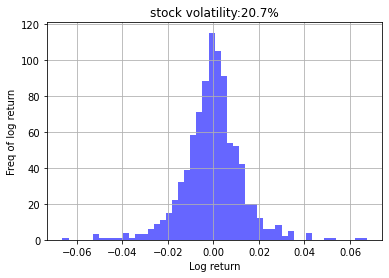

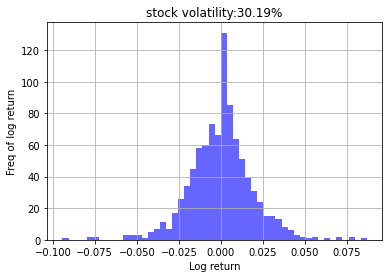

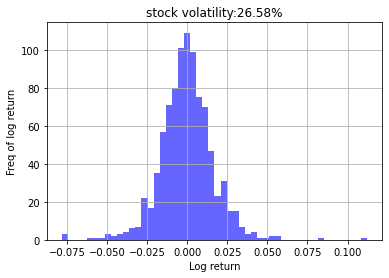

In [93]:

# function for adding returns and volatility to dataframe
def return_and_vola(df):

    # initializing new data frame with columns
    new = pd.DataFrame(columns=stocks.columns)

    # converting close price column to type float so log is appliable
    df['Close'] = df['Close'].astype(float)

    for i in stocks.SecuritiesCode.unique():
        
        # initializing new data frame with columns
        new = pd.DataFrame(columns=df.columns)

        # getting query for security code
        a = df.query('SecuritiesCode == @i')
        
        # getting rsi from function
        a['RSI'] = rsi(a, 14, True)

        # making columns for return and log return
        a['logreturn'] = np.log(a['Close']/a['Close'].shift())
        a['return'] = a['Close']/a['Close'].shift()
        
        # dropping na values
        a = a.dropna(axis=0)


        # making columns for volatility and log volatility
        a['logvol_week'] = a['logreturn'].std()*255**.5
        a['vol_week'] = a['return'].std()*255**.5

        # plotting
        fig, ax = plt.subplots()
        a['logreturn'].hist(ax=ax, bins=50, alpha=0.6, color='b')
        ax.set_xlabel('Log return')
        ax.set_ylabel('Freq of log return')

        # making string for the title
        str_vol = str(round(a['logreturn'].std()*252**.5, 4)*100)
        ax.set_title('stock volatility:'  + str_vol + '%')


        # combining query and new data frame
        new = pd.concat([new, a])

    
    

    

/Users/corneliusbohle/Desktop/tokyo-stock-exchange/.capstone/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='profit_ttm'>

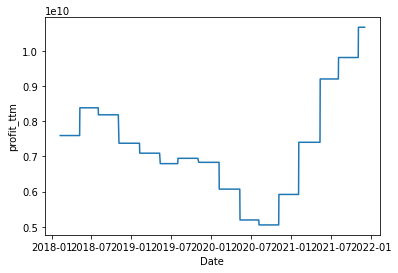

In [55]:
sns.lineplot(stocks.query('SecuritiesCode == 1301').Date, stocks.query('SecuritiesCode == 1301').profit_ttm)